## Data exploration

In [ ]:
#Please install the following libraries before running the code
!pip install imbalanced-learn --quiet
!pip install scikit-learn --quiet


In [3]:
#Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
#split the data into train and test
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
#Load data from a file

train_df = pd.read_csv('/Users/mj/practiceDS/sme-hiring-assessment/machine-learning/data/train_payment_data.csv', sep=',')
train_loan_df = pd.read_csv('/Users/mj/practiceDS/sme-hiring-assessment/machine-learning/data/train_loan_data.csv', sep=',')
test_df = pd.read_csv('/Users/mj/practiceDS/sme-hiring-assessment/machine-learning/data/test_loan_data.csv', sep=',')


In [5]:
#check the data imported
len(train_loan_df)

25102

In [ ]:
#train payment data Bin histogram to check the distribution of the data
train_df.hist(bins=50, figsize=(10,5)) 

In [9]:
#join train_loan_df and train_df to get the amounta paid for the loans 
train_df_joined = pd.merge(train_df, train_loan_df, on='loan_id', how='inner')
len(train_df_joined)    

92152

In [13]:
#check payment  and loan data merged (length and columns) and check missing values
print("length of payment data: ",len(train_df_joined))
print("columns of payment data: ", train_df_joined.columns)
print("data types of payment data: ", train_df_joined.dtypes)
print("--------------------------------------------")

print("missing values in payment data: ", train_df_joined.isnull().sum())
print("--------------------------------------------")

length of payment data:  92152
columns of payment data:  Index(['loan_id', 'paid_at', 'amount', 'transaction_type', 'business_id',
       'credit_officer_id', 'dismissal_description', 'acquisition_channel',
       'sector', 'principal', 'total_owing_at_issue', 'application_number',
       'applying_for_loan_number', 'loan_number', 'employee_count',
       'approval_status', 'paid_late', 'total_recovered_on_time',
       'total_recovered_15_dpd', 'cash_yield_15_dpd'],
      dtype='object')
data types of payment data:  loan_id                       int64
paid_at                      object
amount                      float64
transaction_type             object
business_id                   int64
credit_officer_id           float64
dismissal_description        object
acquisition_channel          object
sector                       object
principal                   float64
total_owing_at_issue        float64
application_number            int64
applying_for_loan_number      int64
loan_numb

In [ ]:
#check loan data  alone (length and columns) and missing values
print("length of train_loan_df: ",len(train_loan_df))
print("columns of train_loan_df: ", train_loan_df.columns)
print("data types of train_loan_df: ", train_loan_df.dtypes)
print("--------------------------------------------")
#check missing values
print("missing values in train_loan_df: ", train_loan_df.isnull().sum())
print("--------------------------------------------")

## How much missing values in the data for train_loan_df
#### this is done to know the number of unique values in the columns. If the missing values are less than 10% of the total data, we can drop the rows with missing values. However, if the missing values are more than 10% of the total data but less than 40% of the data, we can replace the missing values with the mean or median of the column. If the missing values are more than 40% of the total data, we can drop the column

<Axes: >

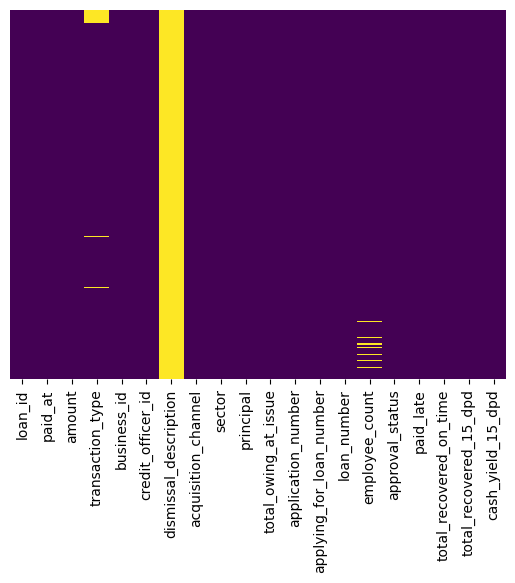

In [15]:
# The heat map tells that "dismissal_description" has 100% missing values. So this column can be dropped
sns.heatmap(train_df_joined.isnull(),yticklabels=False,cbar=False,cmap='viridis')

## Find the inter quartile range.
#### for the train loan data, we determine the lower and the upper boundaries. We do this to find out how mush of the data lies below the lower bound and how many are above the upper bound.This value will be used to determine the outliers. Once they are above the upper bound , we deem them as outliers. This does not mean that the outliers are not usable , however, it helps determine the behaviour in the data. 
#### I have done this for the merged data and the train_loan data seperately. In both cases, I looked at the "total_owing_at_issue"

In [ ]:
#Train_loan_df.
Q1 = train_loan_df['total_owing_at_issue'].quantile(0.25)
Q3 = train_loan_df['total_owing_at_issue'].quantile(0.75)
lower_bound = Q1 - 1.5*(Q3-Q1)
upper_bound = Q3 + 1.5*(Q3-Q1)
print("Q1: ", Q1)
print("Q3: ", Q3)
print("lower interquartile bound: ", lower_bound)
print("upper interquartile bound: ", upper_bound)

In [16]:
#Merge train_loan_df and train_df
Q1 = train_df_joined['total_owing_at_issue'].quantile(0.25)
Q3 = train_df_joined['total_owing_at_issue'].quantile(0.75)
lower_bound = Q1 - 1.5*(Q3-Q1)
upper_bound = Q3 + 1.5*(Q3-Q1)
print("Q1: ", Q1)
print("Q3: ", Q3)
print("lower interquartile bound: ", lower_bound)
print("upper interquartile bound: ", upper_bound)

Q1:  345700.0
Q3:  1000300.0
lower interquartile bound:  -636200.0
upper interquartile bound:  1982200.0


### Outlier investigation
### Number of data points that fall above the  upper bound of the data. We have called these the outliers in the dataset. We investigate the  loan id , busines_id, loan number and payment status (i.e pay_late) with of this  group.  We explore the payment behavior amoung the outlier; i.e. How often do they pay on time

In [18]:
len(train_loan_df[train_loan_df['total_owing_at_issue'] > upper_bound])

9529

In [ ]:
len(train_df_joined[train_df_joined['total_owing_at_issue'] > upper_bound])

In [ ]:
#create a new dataframe with outliers for train_loan_df
outliersdf = train_loan_df[train_loan_df['total_owing_at_issue'] > upper_bound]
print("outliers shape: ", outliersdf.shape)
#Group the outliers by unique business_id
outliers_groupeddf = outliersdf.groupby(['business_id', 'paid_late']).size().reset_index(name='counts')
print("outliers_grouped: ", outliers_groupeddf.head(10))

In [19]:
#create a new dataframe with outliers for train_df_joined
outliers = train_df_joined[train_df_joined['total_owing_at_issue'] > upper_bound]
print("outliers shape: ", outliers.shape)
#Group the outliers by unique business_id
outliers_grouped = outliers.groupby(['business_id', 'paid_late']).size().reset_index(name='counts')
print("outliers_grouped: ", outliers_grouped.head(10))

outliers shape:  (9529, 20)
outliers_grouped:     business_id  paid_late  counts
0         2229      False       6
1         2229       True      14
2         5104      False       3
3         5467      False      54
4         8510      False       2
5         9027      False      20
6        12457      False      37
7        17374      False     305
8        17374       True      31
9        17858      False      89


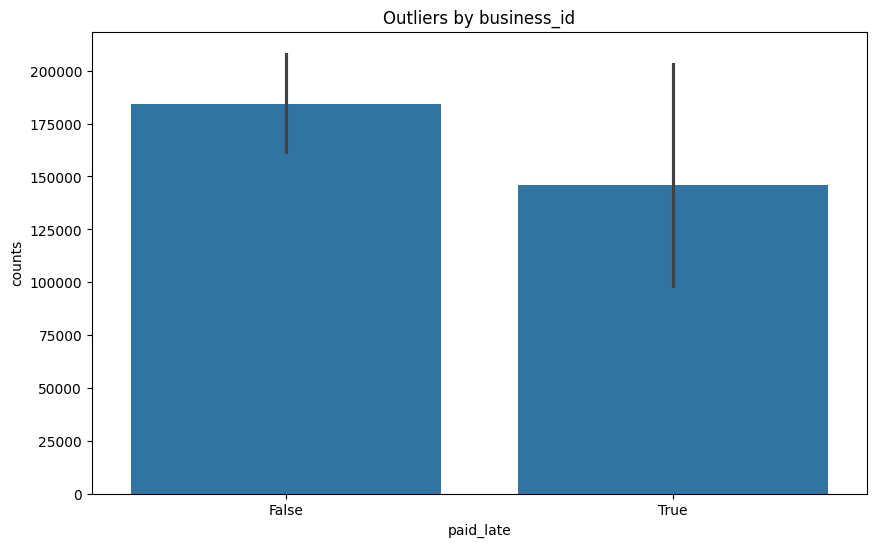

In [20]:
#plot the outliers_grouped  by business id on a bar chart
plt.figure(figsize=(10,6))
sns.barplot(x='paid_late', y='business_id', data=outliers_grouped)
plt.title('Outliers by business_id')
plt.xlabel('paid_late')
plt.ylabel('counts')
plt.show()

In [ ]:
#plot the outliers_grouped  by business id on a bar chart for train_loan_df
plt.figure(figsize=(10,6))
sns.barplot(x='paid_late', y='business_id', data=outliers_groupeddf)
plt.title('Outliers by business_id')
plt.xlabel('paid_late')
plt.ylabel('counts')
plt.show()

#### Having looked at the outliers in both groups. I decided to work  the train_loan_df. This is because in my first interttionof the model. I had to drop all colums from the payment data frame  and the model found them not to usefull. which made it difficult to justify the merging
#### loan ids recovered from the outliers before due date from total_recovered_on_time by business ids

In [21]:

recovery = outliersdf[['business_id','total_recovered_on_time', 'total_recovered_15_dpd']]
print("recovered: ", recovery[['business_id','total_recovered_on_time', 'total_recovered_15_dpd']].value_counts())
#Group by unique business_id
recovery_grp= recovery.groupby(['business_id', 'total_recovered_on_time']).size().reset_index(name='counts')
print("recovered rate : ", recovery_grp.head(10))
len(recovery_grp)



recovered:  business_id  total_recovered_on_time  total_recovered_15_dpd
174942       7273600.0                7273600.0                 123
             5595400.0                5595400.0                 114
173694       4774000.0                4774000.0                 105
             5229300.0                5229300.0                 104
             3044500.0                3044500.0                 103
                                                               ... 
68533        2973800.0                2973800.0                   1
             3033200.0                3033200.0                   1
             3093900.0                3093900.0                   1
             3155700.0                3155700.0                   1
659249       2239000.0                2239000.0                   1
Name: count, Length: 1427, dtype: int64
recovered rate :     business_id  total_recovered_on_time  counts
0         2229                 487600.0       7
1         2229           

1426

In [22]:
#loan ids recovered from the outliers before due date from total_recovered_on_time
recovered_on_time = outliers[outliers['total_recovered_on_time'] > 0]
print("recovered_on_time: ", recovered_on_time[['loan_id', 'business_id']].value_counts())
#Group by unique business_id
recovered_on_time_grouped = recovered_on_time.groupby(['business_id']).size().reset_index(name='counts')
print("recovered_on_time_grouped: ", recovered_on_time_grouped.shape)
len(recovered_on_time_grouped)

recovered_on_time:  loan_id  business_id
904720   173694         105
954924   173694         104
606647   173694         103
754969   173694          94
928494   173694          93
                       ... 
900862   22636            1
533549   128143           1
899950   115846           1
531812   51773            1
923753   300941           1
Name: count, Length: 1608, dtype: int64
recovered_on_time_grouped:  (173, 2)


173

#### Percentage of Outliers who paid late and on time 

In [23]:
#count of unique business_ids who paid late in the outliers
print("count of unique business_ids who paid late in the outliers: ", len(outliers_grouped[outliers_grouped['paid_late'] == 1]))
#percentage of loan_ids who paid on time ain the outliers
print("percentage of loan_ids who paid on time in the outliers: ", len(outliers_grouped[outliers_grouped['paid_late'] == 0])/len(outliers_grouped))
#percentage of loan_ids who paid late in the outliers
print("percentage of loan_ids who paid late in the outliers: ", len(outliers_grouped[outliers_grouped['paid_late'] == 1])/len(outliers_grouped))
#count of loan_ids by business_id in the outliers
print("count of loan_ids by business_id in the outliers: ", len(outliers_grouped))



count of unique business_ids who paid late in the outliers:  30
percentage of loan_ids who paid on time in the outliers:  0.8522167487684729
percentage of loan_ids who paid late in the outliers:  0.1477832512315271
count of loan_ids by business_id in the outliers:  203


# plot the outliers by business id on a bar chart

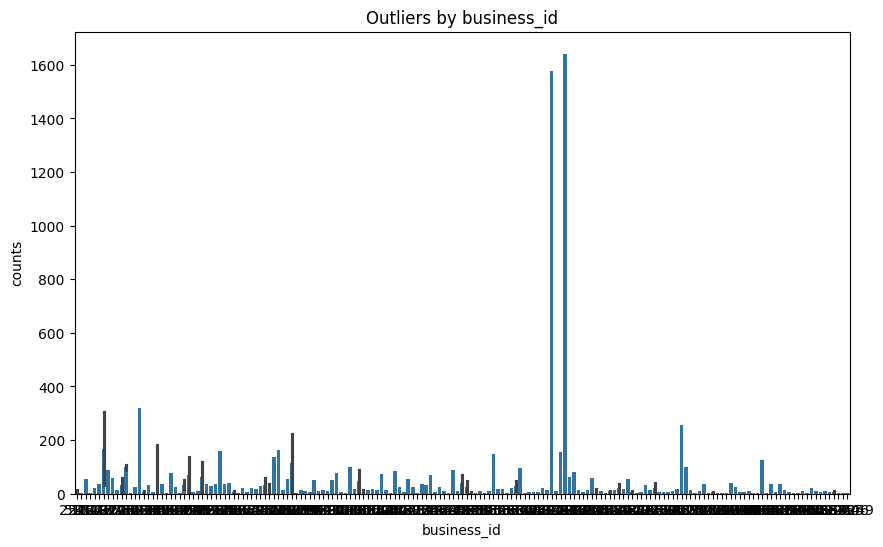

In [24]:

plt.figure(figsize=(10,6))
sns.barplot(x='business_id', y='counts', data=outliers_groupeddf)
plt.title('Outliers by business_id')
plt.xlabel('business_id')
plt.ylabel('counts')
plt.show()

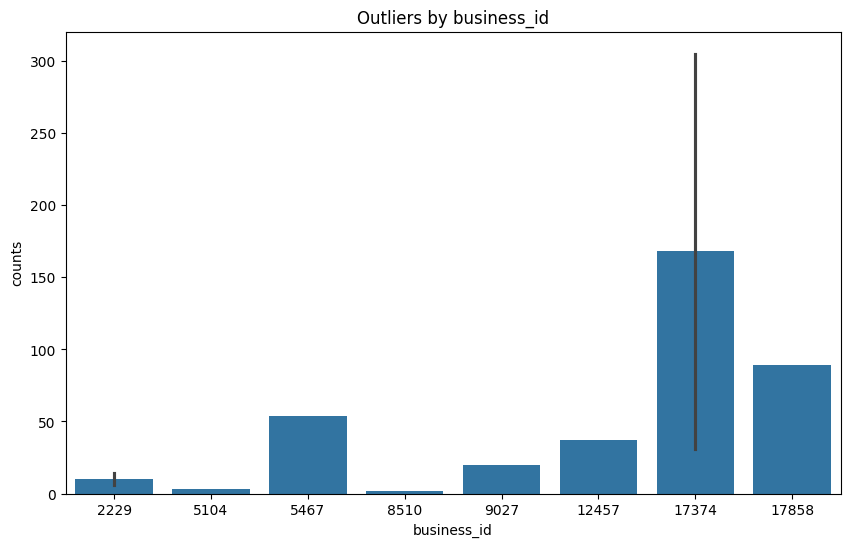

In [25]:
# reduce the data point and plot the outliers_grouped  by business id on a bar chart
plt.figure(figsize=(10,6))
sns.barplot(x='business_id', y='counts', data=outliers_grouped.head(10))
plt.title('Outliers by business_id')
plt.xlabel('business_id')
plt.ylabel('counts')
plt.show()

### Training data
### Create training data excluding Outliers called train_main_data. Given that the outliers behavior showed that even though the amounts were higher, they still paid on time in most cases. We consider them abonus for the bonus . So we exclude the outliers to ensure we have a good view of the behaviour of the data.

In [26]:

#exclude the outliers from the train_loan_df
train_main_data = train_df_joined[train_df_joined['total_owing_at_issue'] < upper_bound]
print("train_main_data shape: ", train_main_data.shape)


train_main_data shape:  (82619, 20)


### find business ids present in the both outliers and in the train_main_data

In [27]:

business_ids = train_main_data[train_main_data['business_id'].isin(outliers['business_id'])]
print("business_ids: ", business_ids.shape)
#count of unique business_ids 
print("count of unique business_ids in both outlier data and main data: ", len(business_ids['business_id'].unique()))
#count of unique business_ids in the train_main_data
print("count of unique business_ids in the train_main_data: ", len(train_main_data['business_id'].unique()))
#count of unique business_ids in the outliers
print("count of unique business_ids in the outliers: ", len(outliers['business_id'].unique()))

business_ids:  (11369, 20)
count of unique business_ids in both outlier data and main data:  173
count of unique business_ids in the train_main_data:  1869
count of unique business_ids in the outliers:  173


### find missing values in the outliers and train_main_data

In [28]:

print("missing values in outliers: ", outliers.isnull().sum())
#find missing values in the train_main_data
print("missing values in train_main_data: ", train_main_data.isnull().sum())


missing values in outliers:  loan_id                        0
paid_at                        0
amount                         0
transaction_type             473
business_id                    0
credit_officer_id              0
dismissal_description       9529
acquisition_channel            0
sector                         0
principal                      0
total_owing_at_issue           0
application_number             0
applying_for_loan_number       0
loan_number                    0
employee_count                 1
approval_status                0
paid_late                      0
total_recovered_on_time        0
total_recovered_15_dpd         0
cash_yield_15_dpd              0
dtype: int64
missing values in train_main_data:  loan_id                         0
paid_at                         0
amount                          0
transaction_type             3074
business_id                     0
credit_officer_id               0
dismissal_description       82603
acquisition_channel     

In [154]:
train_main_data = train_loan_df[train_loan_df['total_owing_at_issue'] < upper_bound]
#fill the missing values in the outliers
outliers['employee_count'].fillna(outliers['employee_count'].mean(), inplace=True)

##fill the missing values in the train_main_data
train_main_data['employee_count'].fillna(train_main_data['employee_count'].mean(), inplace=True)


/var/folders/h8/d5nvj1k54gnb70khql_g92rr0000gn/T/ipykernel_18324/3020584774.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  outliers['employee_count'].fillna(outliers['employee_count'].mean(), inplace=True)
/var/folders/h8/d5nvj1k54gnb70khql_g92rr0000gn/T/ipykernel_18324/3020584774.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlie

### check imbalance in the data

imbalance in the data:  paid_late
False    0.970517
True     0.029483
Name: proportion, dtype: float64


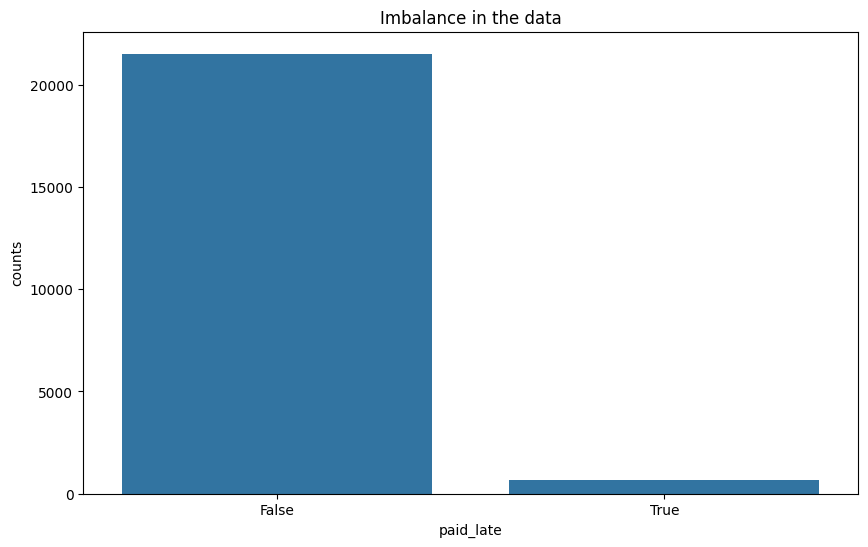

In [155]:
#check imbalance in the data
print("imbalance in the data: ", train_main_data['paid_late'].value_counts(normalize=True))
#plot the imbalance in the data
plt.figure(figsize=(10,6))
sns.countplot(x='paid_late', data=train_main_data)
plt.title('Imbalance in the data')
plt.xlabel('paid_late')
plt.ylabel('counts')
plt.show()

# the pay_late seems more likely as the choice of target variable given the above view. However, we still plot the data and check other potential candidates

In [148]:
#train loan data Bin histogram. To check the distribution of the data
train_main_data.hist(bins=50, figsize=(15,10))

#loan status in plot the status of the loan as potential target variable
train_loan_df['approval_status'].value_counts().plot(kind='bar')

In [183]:

#create train data
Xloan = train_main_data.drop('paid_late', axis=1)
yloan = train_main_data['paid_late']


In [184]:
Xloan.columns

Index(['loan_id', 'business_id', 'credit_officer_id', 'dismissal_description',
       'acquisition_channel', 'sector', 'principal', 'total_owing_at_issue',
       'application_number', 'applying_for_loan_number', 'loan_number',
       'employee_count', 'approval_status', 'total_recovered_on_time',
       'total_recovered_15_dpd', 'cash_yield_15_dpd'],
      dtype='object')

### drop columns that willnot be used in the model and split the data into train and test

In [ ]:
Xloan = Xloan.drop('credit_officer_id', axis=1)
Xloan = Xloan.drop('acquisition_channel', axis=1)
Xloan = Xloan.drop('applying_for_loan_number', axis=1)
Xloan = Xloan.drop('dismissal_description', axis=1)
# Xloan = Xloan.drop('paid_at', axis=1)
# Xloan = Xloan.drop('transaction_type', axis=1)
#Xloan = Xloan.drop('loan_id', axis=1)
#Xloan = Xloan.drop('business_id', axis=1)
# Xloan = Xloan.drop('amount', axis=1)


In [187]:
#convert the categorical columns to one hot encoding
Xloan = pd.get_dummies(Xloan, columns=['business_id'], drop_first=True)
Xloan = pd.get_dummies(Xloan, columns=['loan_id'], drop_first=True)
Xloan = pd.get_dummies(Xloan, columns=['sector'], drop_first=True)
Xloan = pd.get_dummies(Xloan, columns=['approval_status'], drop_first=True)

In [188]:
X_train, X_test, y_train, y_test = train_test_split(Xloan, yloan, test_size=0.2, random_state=42)

### Resample data due to imbalance and also get categorical columns from the data and with onehot, encode them on the categorical columns

In [189]:
#apply SMOTE to balance the data
from imblearn.over_sampling import SMOTE

categorical_columns = Xloan.select_dtypes(include=['object']).columns
print("categorical_columns: ", categorical_columns)

categorical_columns:  Index([], dtype='object')


### Normalize the data and resample with SMOTE

In [171]:
os = SMOTE(sampling_strategy=0.8,random_state=42)

In [190]:

X_train_res, y_train_res = os.fit_resample(X_train,y_train)
X_train_res.shape, y_train_res.shape

((30974, 22577), (30974,))

### target variable paid_late

In [191]:
#Use random forest classifier to predict the target variable paid_late

X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns)
rf = RandomForestClassifier(n_estimators= 30, random_state=42)
rf.fit(X_train_res, y_train_res)
y_pred = rf.predict(X_test)

print("classification report: ", classification_report(y_test, y_pred))
print("confusion matrix: ", confusion_matrix(y_test, y_pred))
train_pred = rf.predict(X_train)
print("classification report: ", classification_report(y_train, train_pred))
print("confusion matrix: ", confusion_matrix(y_train, train_pred))



classification report:                precision    recall  f1-score   support

       False       0.99      1.00      0.99      4320
        True       0.97      0.63      0.77       117

    accuracy                           0.99      4437
   macro avg       0.98      0.82      0.88      4437
weighted avg       0.99      0.99      0.99      4437

confusion matrix:  [[4318    2]
 [  43   74]]
classification report:                precision    recall  f1-score   support

       False       1.00      1.00      1.00     17208
        True       1.00      1.00      1.00       537

    accuracy                           1.00     17745
   macro avg       1.00      1.00      1.00     17745
weighted avg       1.00      1.00      1.00     17745

confusion matrix:  [[17208     0]
 [    0   537]]


In [192]:
#predict the target variable paid_late on the full data
y_pred_full = rf.predict(Xloan)
print("classification_report_full: ", classification_report(yloan, y_pred_full))    
print("confusion_matrix_full: ", confusion_matrix(yloan, y_pred_full))

classification_report_full:                precision    recall  f1-score   support

       False       1.00      1.00      1.00     21528
        True       1.00      0.93      0.96       654

    accuracy                           1.00     22182
   macro avg       1.00      0.97      0.98     22182
weighted avg       1.00      1.00      1.00     22182

confusion_matrix_full:  [[21526     2]
 [   43   611]]


## Save trained model

In [193]:
#save the model to a file for later use
import joblib
joblib.dump(rf, 'model.pkl')


['model.pkl']

## model evaluation

In [210]:
test_df = pd.read_csv('/Users/mj/practiceDS/sme-hiring-assessment/machine-learning/data/test_loan_data.csv', sep=',')
test_df.columns

Index(['loan_id', 'business_id', 'credit_officer_id', 'dismissal_description',
       'acquisition_channel', 'sector', 'principal', 'total_owing_at_issue',
       'application_number', 'applying_for_loan_number', 'loan_number',
       'employee_count', 'approval_status', 'payment_status', 'paid_late',
       'total_recovered_on_time', 'total_recovered_15_dpd',
       'cash_yield_15_dpd'],
      dtype='object')

In [211]:
print("missing values in train_main_data: ", test_df.isnull().sum())

missing values in train_main_data:  loan_id                        0
business_id                    0
credit_officer_id              0
dismissal_description       2000
acquisition_channel            0
sector                         0
principal                      0
total_owing_at_issue           0
application_number             0
applying_for_loan_number       0
loan_number                    0
employee_count               387
approval_status                0
payment_status                 0
paid_late                      0
total_recovered_on_time        1
total_recovered_15_dpd         1
cash_yield_15_dpd              1
dtype: int64


In [ ]:
#predict the test data

test_df = test_df.drop('credit_officer_id', axis=1)
test_df = test_df.drop('acquisition_channel', axis=1)
#test_df = test_df.drop('loan_id', axis=1)
#test_df = test_df.drop('business_id', axis=1)
test_df = test_df.drop('applying_for_loan_number', axis=1)
test_df = test_df.drop('paid_late', axis=1)
test_df = test_df.drop('payment_status', axis=1)
test_df = test_df.drop('dismissal_description', axis=1)
test_df = pd.get_dummies(test_df, columns=['approval_status'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['sector'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['business_id'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['loan_id'], drop_first=True)


In [ ]:
#predict the test data
y_pred_test = rf.predict(test_df)
test_df['paid_late_predict'] = y_pred_test
test_df.to_csv('/Users/mj/practiceDS/sme-hiring-assessment/machine-learning/model_output/test_loan_result.csv', index=False)



In [182]:
test_df.columns

Index(['principal', 'total_owing_at_issue', 'application_number',
       'loan_number', 'employee_count', 'total_recovered_on_time',
       'total_recovered_15_dpd', 'cash_yield_15_dpd', 'sector_Agro Input',
       'sector_Arts Media', 'sector_Autoparts Hardware',
       'sector_Beauty Fashion', 'sector_Drugshop', 'sector_Food Staple Goods',
       'sector_Health Clinic', 'sector_Hospitality', 'sector_Manufacturing',
       'sector_Metal and Woodworking', 'sector_Mobile Money Airtime',
       'sector_Other', 'sector_Phones Electronics', 'sector_Repairs Cleaning',
       'sector_School', 'sector_Stationary Printing', 'sector_Transportation',
       'sector_Wholesale', 'paid_late_predict'],
      dtype='object')

In [212]:
#group test_df by business_id, paid_late_predict and count
test_grouped = test_df.groupby(['loan_id']).size().reset_index(name='counts')
#len(test_grouped)
print("test_grouped: ", test_grouped.shape)
print("test_grouped: ", test_grouped.head(10))

test_grouped:  (2000, 2)
test_grouped:     loan_id  counts
0   982947       1
1   983014       1
2   983064       1
3   983337       1
4   983542       1
5   984333       1
6   984623       1
7   984710       1
8   984715       1
9   984730       1


## Feature importance

In [179]:
#feature importance columns
feature_importance = pd.DataFrame(rf.feature_importances_, index=Xloan.columns, columns=['importance'])
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("feature_importance: ", feature_importance)

feature_importance:                                importance
total_recovered_on_time         0.553033
employee_count                  0.071782
sector_Beauty Fashion           0.060448
total_recovered_15_dpd          0.048902
principal                       0.039133
total_owing_at_issue            0.036516
sector_Phones Electronics       0.028394
sector_Stationary Printing      0.027296
cash_yield_15_dpd               0.023824
loan_number                     0.021252
sector_Drugshop                 0.018392
sector_Autoparts Hardware       0.013072
application_number              0.012213
sector_Food Staple Goods        0.012081
sector_Health Clinic            0.010164
sector_Mobile Money Airtime     0.010016
sector_Wholesale                0.005489
sector_Other                    0.002683
sector_Arts Media               0.001756
sector_Manufacturing            0.001467
sector_Transportation           0.001364
sector_Hospitality              0.000579
sector_Repairs Cleaning         0.00

<Axes: >

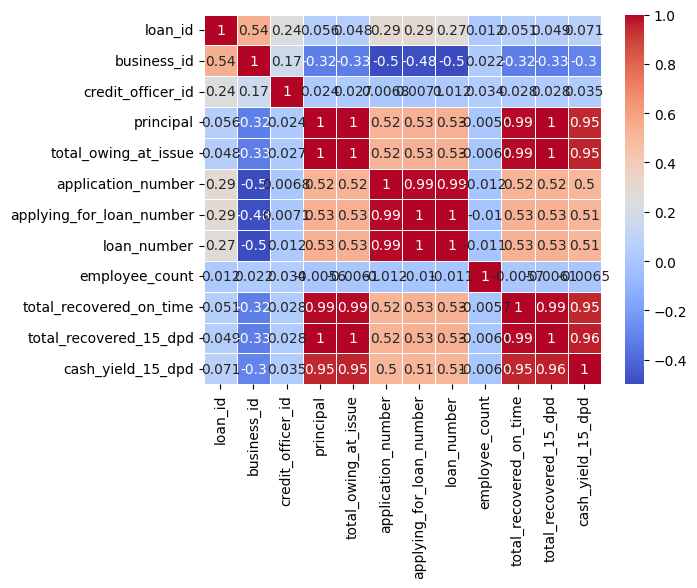

In [213]:
#remove non numeric columns
train_loan_df_corr = train_loan_df.select_dtypes(include=[np.number])
#train_loan_df_corr.head()
#fine correlation
corr = train_loan_df_corr.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)